# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

C:\Users\jamr1\AppData\Local\Temp\ipykernel_16692\2644636387.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1).

In [2]:
class_names = ['mountain','street','glacier', 'buildings','sea','forest']

IMAGE_SIZE = (32,32)

In [3]:
class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [4]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\Prof\\seg_train (1)\\" 
TEST_PATH = ROOT_PATH + "\\Prof\\seg_test (1)\\seg_test\\"

In [5]:
def read_data(path, im_size, class_names_label):
    X = []
    y = []
    for folder in os.listdir(path):
        label = class_names_label[folder]
        folder_path = os.path.join(path,folder)
        # Iterar sobre todo lo que haya en path
        for file in os.listdir(folder_path):
            
            image_path = os.path.join(folder_path,file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, im_size) # Ya lo aplicó el resize
            
            X.append(image)
            y.append(label)
            
    return np.array(X), np.array(y)

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE, class_names_label)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE, class_names_label)

print(X_train.shape)
print(X_test.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)


### 2).

(32, 32, 3)


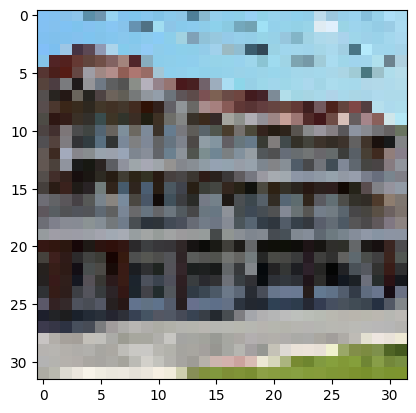

In [7]:
print(X_train[2].shape)
plt.imshow(X_train[2]);

### 3).

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


### 4).

In [9]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train

array([[[[0.88235294, 0.88235294, 0.88235294],
         [0.86666667, 0.8745098 , 0.87058824],
         [0.86666667, 0.8745098 , 0.87058824],
         ...,
         [0.92941176, 0.92941176, 0.92941176],
         [0.93333333, 0.93333333, 0.93333333],
         [0.94117647, 0.94117647, 0.94117647]],

        [[0.90196078, 0.90196078, 0.90196078],
         [0.89019608, 0.89019608, 0.89019608],
         [0.90980392, 0.90980392, 0.90980392],
         ...,
         [0.95686275, 0.95686275, 0.95686275],
         [0.95686275, 0.95686275, 0.95686275],
         [0.96470588, 0.96470588, 0.96470588]],

        [[0.21568627, 0.21568627, 0.21568627],
         [0.8745098 , 0.8745098 , 0.8745098 ],
         [0.34509804, 0.34117647, 0.34509804],
         ...,
         [0.96078431, 0.96078431, 0.96078431],
         [0.96470588, 0.96470588, 0.96470588],
         [0.96470588, 0.96470588, 0.96470588]],

        ...,

        [[0.44705882, 0.43921569, 0.43529412],
         [0.38039216, 0.37647059, 0.36862745]

In [10]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

In [11]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [14]:
from tensorflow import keras

IMAGE_SIZE = (32, 32, 1)  # Definir el tamaño de la imagen

layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(6, activation='softmax')
]

model = keras.Sequential(layers)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Cambiado a sparse_categorical_crossentropy para multiclase
              metrics=['accuracy'])


El error que estabas experimentando, que indicaba que la entrada de la capa `Conv2D` tenía una dimensión incompatible, era probablemente debido a un desajuste entre la forma de `input_shape` especificada y la forma real de tus datos de entrada.

Cuando defines un modelo en Keras, la capa de convolución espera recibir datos en un formato específico, que generalmente es `(altura, anchura, canales)`. Si la forma especificada en `input_shape` no coincide con la forma real de tus datos de entrada, Keras lanzará un error.

En tu caso, el error se resolvió cuando ajustaste `input_shape` a `(32, 32, 1)` para reflejar el tamaño correcto de tus imágenes en escala de grises. Es importante que esta dimensión sea precisa para garantizar que el modelo pueda procesar correctamente los datos de entrada.

En resumen, el error probablemente se debió a una discrepancia entre la forma especificada en `input_shape` y la forma real de tus datos de entrada, y se resolvió ajustando `input_shape` para que coincida con el tamaño y el número de canales de tus imágenes.

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

### 5).

In [ ]:
TRAIN_PATH = os.getcwd() + '\\Prof\\data\\seg_train'
TEST_PATH = os.getcwd() + '\\Prof\\data\\seg_test'

In [8]:
def read_data(path, im_size, class_names_label):
    X = []
    y = []

    for folder in os.listdir(path):
        label = class_names_label[folder]
        folder_path = os.path.join(path,folder)
        # Iterar sobre todo lo que haya en path
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path,file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, im_size)
            X.append(image)
            y.append(label)
    
    
    return np.array(X), np.array(y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE, class_names_label)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE, class_names_label)

print(X_train.shape)
print(X_test.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)


In [17]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [18]:
y_train

array([3, 1, 1, ..., 2, 3, 0])

## 2. Mostrar imágenes

forest


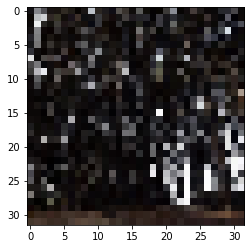

In [26]:
index = np.random.randint(X_train.shape[0])
print(class_names[y_train[index]])
plt.imshow(X_train[index]);

## 3. Normalización

In [27]:
X_train_scal = X_train/255.0
X_test_scal = X_test/255.0

## 4. Diseñar la RRNN